# Data cleaning

In [16]:
import pandas as pd
import numpy as np
import re
import time

import matplotlib.pyplot as plt
import seaborn as sns

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
# from xgboost import XGBRegressor

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV

### Booking csv

In [43]:
df_b = pd.read_csv('booking_hotels_with_address.csv')
df_b['source'] = 'booking'
print(df_b.shape)
print(df_b.head())

(800, 12)
                                  name  price  nro_of_nights  star_rating  \
0  The Muse Amsterdam - Boutique Hotel    782              1          3.0   
1             citizenM Amsterdam South    807              1          4.0   
2            Ruby Emma Hotel Amsterdam    733              1          4.0   
3     Inntel Hotels Amsterdam Landmark   1175              1          4.0   
4                    Urban Lodge Hotel    672              1          4.0   

   review_score  review_count                     room_type  \
0           8.3        2082.0             Small Double Room   
1           8.7        5903.0                     King Room   
2           8.8        8994.0                     Mate Room   
3           8.2       10966.0                City Twin Room   
4           8.3        3000.0  Standard Double or Twin Room   

            part_of_city  distance_from_center  \
0               Oud Zuid                   2.3   
1           Zuideramstel                   3.6  

In [ ]:
# Dublicates and null values

print(df_b.duplicated().sum())
print(df_b.isnull().sum())

0
name                      0
price                     0
nro_of_nights             0
star_rating             148
review_score             21
review_count             15
room_type                 0
part_of_city              0
distance_from_center      0
url                       0
address                   0
source                    0
dtype: int64


In [ ]:
# Drop rowss with review_score null

df_b = df_b.dropna(subset=['review_score'])
print(df_b.shape)
print(df_b.isnull().sum())

(779, 12)
name                      0
price                     0
nro_of_nights             0
star_rating             138
review_score              0
review_count              0
room_type                 0
part_of_city              0
distance_from_center      0
url                       0
address                   0
source                    0
dtype: int64


In [ ]:
# Divide price by 7 to get price per night

df_b['price'] = (df_b['price'] / 7).round(2)
df_b.head()

,name,price,nro_of_nights,star_rating,review_score,review_count,room_type,part_of_city,distance_from_center,url,address,source
0,The Muse Amsterdam - Boutique Hotel,111.71,1,3.0,8.3,2082.0,Small Double Room,Oud Zuid,2.3,https://www.booking.com/hotel/nl/bronckhorst.e...,"Bronckhorststraat 14, Oud Zuid, 1071 WR Amster...",booking
1,citizenM Amsterdam South,115.29,1,4.0,8.7,5903.0,King Room,Zuideramstel,3.6,https://www.booking.com/hotel/nl/citizenm-amst...,"Prinses Irenestraat 30, Zuideramstel, 1077 WX ...",booking
2,Ruby Emma Hotel Amsterdam,104.71,1,4.0,8.8,8994.0,Mate Room,Oost,4.3,https://www.booking.com/hotel/nl/ruby-emma.en-...,"Amstelvlietstraat 4, Oost, 1096 GG Amsterdam, ...",booking
3,Inntel Hotels Amsterdam Landmark,167.86,1,4.0,8.2,10966.0,City Twin Room,Amsterdam City Centre,2.4,https://www.booking.com/hotel/nl/inntel-hotels...,"VOC-kade 600, Amsterdam City Centre, 1018 LG A...",booking
4,Urban Lodge Hotel,96.00,1,4.0,8.3,3000.0,Standard Double or Twin Room,Westpoort,4.2,https://www.booking.com/hotel/nl/urban-lodge.e...,"Arlandaweg 10, Westpoort, 1043 EW Amsterdam, N...",booking


In [ ]:
# Values in room_type column

df_b['room_type'].value_counts()

room_type
Double Room                                                  52
Double Room with Private Bathroom                            35
One-Bedroom Apartment                                        34
Two-Bedroom Apartment                                        29
Twin Room                                                    26
                                                             ..
At the Beach (Ground floor or first floor)                    1
Queen Room with Shared Bathroom                               1
Twin Room with Bunk Beds and Private Bathroom with Shower     1
Queen Room without Window                                     1
Superior Suite with Sea View                                  1
Name: count, Length: 299, dtype: int64

In [ ]:
# Values in part_of_city column

df_b['part_of_city'].value_counts()

part_of_city
Amsterdam City Centre    395
Amsterdam Noord           59
Oud Zuid                  55
Oud-West                  45
Oost                      34
De Pijp                   32
Zuideramstel              30
Zeeburg                   19
Slotervaart               16
Westpoort                 16
Westerpark                15
IJburg                    15
Zuidoost                  12
Bos en Lommer             10
Geuzenveld-Slotermeer      9
Osdorp                     7
Amsterdam                  4
De Baarsjes                3
Bijlmermeer                2
Sloterdijk                 1
Name: count, dtype: int64

In [50]:
# -------------------
# Address Cleaning Function
# -------------------
def clean_address(address):
    """
    Keep only: street, number, postal code, city, country.
    Removes districts (e.g. Zuideramstel) and Booking.com extra text.
    """
    if pd.isna(address):
        return None

    # Take only before the newline (drop Booking disclaimer)
    address = address.split("\n")[0]

    # Regex: remove middle parts (districts) between street and postal code
    # Example: "Street 30, Zuideramstel, 1077 WX Amsterdam, Netherlands"
    # -> "Street 30, 1077 WX Amsterdam, Netherlands"
    address = re.sub(r",\s*[A-Za-z\s]+,\s*(\d{4}\s?[A-Z]{2})", r", \1", address)

    return address.strip()

# Apply cleaning
df_b["clean_address"] = df_b["address"].apply(clean_address)
df_b['clean_address'].head()

0    Bronckhorststraat 14, 1071 WR Amsterdam, Nethe...
1    Prinses Irenestraat 30, 1077 WX Amsterdam, Net...
2    Amstelvlietstraat 4, 1096 GG Amsterdam, Nether...
3         VOC-kade 600, 1018 LG Amsterdam, Netherlands
4        Arlandaweg 10, 1043 EW Amsterdam, Netherlands
Name: clean_address, dtype: object

In [ ]:
# Getting latitude and longitude with geopy based on clean_address

# -------------------
# SETUP
# -------------------
geolocator = Nominatim(user_agent="booking_geocoder")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1, max_retries=2, error_wait_seconds=5)

df_b['latitude'] = None
df_b['longitude'] = None
failed_addresses = []

# -------------------
# FIRST PASS: MAIN GEOCODING WITH PROGRESS
# -------------------
print("Starting geocoding first pass...")
for idx, row in tqdm(df_b.iterrows(), total=len(df_b), desc="Geocoding"):
    address = row['clean_address']
    try:
        location = geocode(address)
        if location:
            df_b.at[idx, 'latitude'] = location.latitude
            df_b.at[idx, 'longitude'] = location.longitude
        else:
            failed_addresses.append((idx, address))
    except Exception as e:
        failed_addresses.append((idx, address))
    time.sleep(0.1)  # extra polite delay

print(f"First pass complete. {len(failed_addresses)} addresses failed.")

# -------------------
# SECOND PASS: RETRY FAILED ADDRESSES
# -------------------
if failed_addresses:
    print("Retrying failed addresses...")
    retry_failed = []
    for idx, address in tqdm(failed_addresses, desc="Retrying"):
        try:
            location = geocode(address)
            if location:
                df_b.at[idx, 'latitude'] = location.latitude
                df_b.at[idx, 'longitude'] = location.longitude
            else:
                retry_failed.append((idx, address))
        except:
            retry_failed.append((idx, address))
        time.sleep(0.1)
    print(f"Second pass complete. {len(retry_failed)} addresses could not be geocoded.")
else:
    retry_failed = []

# -------------------
# SAVE RESULTS
# -------------------
df_b.to_csv("booking_hotels_geocoded.csv", index=False)
print("All done! Geocoding results saved to 'booking_hotels_geocoded.csv'.")

Starting geocoding first pass...


Geocoding:   2%|▏         | 13/779 [00:12<13:56,  1.09s/it]RateLimiter caught an error, retrying (0/2 tries). Called with (*('Singel 303 - 309, 1012 WJ Amsterdam, Netherlands',), **{}).
Traceback (most recent call last):
  File "/opt/anaconda3/envs/final_proj/lib/python3.10/site-packages/urllib3/connectionpool.py", line 534, in _make_request
    response = conn.getresponse()
  File "/opt/anaconda3/envs/final_proj/lib/python3.10/site-packages/urllib3/connection.py", line 565, in getresponse
    httplib_response = super().getresponse()
  File "/opt/anaconda3/envs/final_proj/lib/python3.10/http/client.py", line 1375, in getresponse
    response.begin()
  File "/opt/anaconda3/envs/final_proj/lib/python3.10/http/client.py", line 318, in begin
    version, status, reason = self._read_status()
  File "/opt/anaconda3/envs/final_proj/lib/python3.10/http/client.py", line 279, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "/opt/anaconda3/envs/final_proj/lib/p

First pass complete. 82 addresses failed.
Retrying failed addresses...


Retrying:  12%|█▏        | 10/82 [00:10<01:12,  1.01s/it]RateLimiter caught an error, retrying (0/2 tries). Called with (*('Jan van Galenstraat 335 Star House building, 1061 AZ Amsterdam, Netherlands',), **{}).
Traceback (most recent call last):
  File "/opt/anaconda3/envs/final_proj/lib/python3.10/site-packages/urllib3/connectionpool.py", line 534, in _make_request
    response = conn.getresponse()
  File "/opt/anaconda3/envs/final_proj/lib/python3.10/site-packages/urllib3/connection.py", line 565, in getresponse
    httplib_response = super().getresponse()
  File "/opt/anaconda3/envs/final_proj/lib/python3.10/http/client.py", line 1375, in getresponse
    response.begin()
  File "/opt/anaconda3/envs/final_proj/lib/python3.10/http/client.py", line 318, in begin
    version, status, reason = self._read_status()
  File "/opt/anaconda3/envs/final_proj/lib/python3.10/http/client.py", line 279, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "/opt/anacon

Second pass complete. 81 addresses could not be geocoded.
All done! Geocoding results saved to 'booking_hotels_geocoded.csv'.


In [79]:
# Checking null values in latitude and longitude

print(df_b[['latitude', 'longitude']].isnull().sum())

latitude     79
longitude    79
dtype: int64


In [67]:
# Aligning review_score with review_scores_rating

df_b['review_score'] = (df_b['review_score'] / 2).round(2)
df_b.head()

,name,price,nro_of_nights,star_rating,review_score,review_count,room_type,part_of_city,distance_from_center,url,address,source,clean_address,latitude,longitude
0,The Muse Amsterdam - Boutique Hotel,111.71,1,3.0,4.15,2082.0,Small Double Room,Oud Zuid,2.3,https://www.booking.com/hotel/nl/bronckhorst.e...,"Bronckhorststraat 14, Oud Zuid, 1071 WR Amster...",booking,"Bronckhorststraat 14, 1071 WR Amsterdam, Nethe...",52.353106,4.880981
1,citizenM Amsterdam South,115.29,1,4.0,4.35,5903.0,King Room,Zuideramstel,3.6,https://www.booking.com/hotel/nl/citizenm-amst...,"Prinses Irenestraat 30, Zuideramstel, 1077 WX ...",booking,"Prinses Irenestraat 30, 1077 WX Amsterdam, Net...",52.341942,4.875972
2,Ruby Emma Hotel Amsterdam,104.71,1,4.0,4.40,8994.0,Mate Room,Oost,4.3,https://www.booking.com/hotel/nl/ruby-emma.en-...,"Amstelvlietstraat 4, Oost, 1096 GG Amsterdam, ...",booking,"Amstelvlietstraat 4, 1096 GG Amsterdam, Nether...",52.33831,4.920732
3,Inntel Hotels Amsterdam Landmark,167.86,1,4.0,4.10,10966.0,City Twin Room,Amsterdam City Centre,2.4,https://www.booking.com/hotel/nl/inntel-hotels...,"VOC-kade 600, Amsterdam City Centre, 1018 LG A...",booking,"VOC-kade 600, 1018 LG Amsterdam, Netherlands",52.373409,4.928381
4,Urban Lodge Hotel,96.00,1,4.0,4.15,3000.0,Standard Double or Twin Room,Westpoort,4.2,https://www.booking.com/hotel/nl/urban-lodge.e...,"Arlandaweg 10, Westpoort, 1043 EW Amsterdam, N...",booking,"Arlandaweg 10, 1043 EW Amsterdam, Netherlands",52.385258,4.834363


In [72]:
# Filter rows where neighbourhood is exactly "Amsterdam" 

amsterdam_rows = df_b[df_b['part_of_city'] == "Amsterdam"]
print(amsterdam_rows['address'])

218    Ellermanstraat 31, 1114 AK Amsterdam, Netherla...
262    Verlengde van Marwijk Kooystraat 30,, 1114 AC ...
666    Arent Krijtsstraat 5, 1111 AG Amsterdam, Nethe...
695    Burgemeester de Kievietstraat 63, 1111 GL Amst...
Name: address, dtype: object


In [73]:
# Drop rows where part_of_city is exactly "Amsterdam"
df_b = df_b[df_b['part_of_city'] != "Amsterdam"]

# Check
print(df_b['part_of_city'].value_counts())

part_of_city
Amsterdam City Centre    395
Amsterdam Noord           59
Oud Zuid                  55
Oud-West                  45
Oost                      34
De Pijp                   32
Zuideramstel              30
Zeeburg                   19
Westpoort                 16
Slotervaart               16
IJburg                    15
Westerpark                15
Zuidoost                  12
Bos en Lommer             10
Geuzenveld-Slotermeer      9
Osdorp                     7
De Baarsjes                3
Bijlmermeer                2
Sloterdijk                 1
Name: count, dtype: int64


In [78]:
df_b['neighbourhood_norm'] = df_b['part_of_city']
df_b.head()

,name,price,nro_of_nights,star_rating,review_score,review_count,room_type,part_of_city,distance_from_center,url,address,source,clean_address,latitude,longitude,neighbourhood_norm
0,The Muse Amsterdam - Boutique Hotel,111.71,1,3.0,4.15,2082.0,Small Double Room,Oud Zuid,2.3,https://www.booking.com/hotel/nl/bronckhorst.e...,"Bronckhorststraat 14, Oud Zuid, 1071 WR Amster...",booking,"Bronckhorststraat 14, 1071 WR Amsterdam, Nethe...",52.353106,4.880981,Oud Zuid
1,citizenM Amsterdam South,115.29,1,4.0,4.35,5903.0,King Room,Zuideramstel,3.6,https://www.booking.com/hotel/nl/citizenm-amst...,"Prinses Irenestraat 30, Zuideramstel, 1077 WX ...",booking,"Prinses Irenestraat 30, 1077 WX Amsterdam, Net...",52.341942,4.875972,Zuideramstel
2,Ruby Emma Hotel Amsterdam,104.71,1,4.0,4.40,8994.0,Mate Room,Oost,4.3,https://www.booking.com/hotel/nl/ruby-emma.en-...,"Amstelvlietstraat 4, Oost, 1096 GG Amsterdam, ...",booking,"Amstelvlietstraat 4, 1096 GG Amsterdam, Nether...",52.33831,4.920732,Oost
3,Inntel Hotels Amsterdam Landmark,167.86,1,4.0,4.10,10966.0,City Twin Room,Amsterdam City Centre,2.4,https://www.booking.com/hotel/nl/inntel-hotels...,"VOC-kade 600, Amsterdam City Centre, 1018 LG A...",booking,"VOC-kade 600, 1018 LG Amsterdam, Netherlands",52.373409,4.928381,Amsterdam City Centre
4,Urban Lodge Hotel,96.00,1,4.0,4.15,3000.0,Standard Double or Twin Room,Westpoort,4.2,https://www.booking.com/hotel/nl/urban-lodge.e...,"Arlandaweg 10, Westpoort, 1043 EW Amsterdam, N...",booking,"Arlandaweg 10, 1043 EW Amsterdam, Netherlands",52.385258,4.834363,Westpoort


In [165]:
# We need to map all Booking room types into the four broader categories for concistensy with Airbnb: 
# "Entire home/apt", "Private room", "Shared room", "Hotel room"

# Define a mapping function
def map_room_type_booking(room):
    if room is None:
        return None
    room_lower = room.lower()
    if "entire" in room_lower or "apartment" in room_lower or "suite" in room_lower or "villa" in room_lower or "house" in room_lower or "cottage" in room_lower or "bungalow" in room_lower or "condo" in room_lower or "residence" in room_lower or "home" in room_lower:
        return "Entire home/apt"
    elif "private" in room_lower:
        return "Private room"
    elif "hotel" in room_lower or "room" in room_lower or "single" in room_lower or "double" in room_lower or "twin" in room_lower:
        return "Hotel room"
    elif "shared" in room_lower or "dorm" in room_lower:
        return "Shared room"
    else:
        return "Hotel room"  # fallback

# Apply to your Booking dataframe
df_b['room_type_clean'] = df_b['room_type'].apply(map_room_type_booking)

# Check distribution
print(df_b['room_type_clean'].value_counts())

room_type_clean
Hotel room         529
Entire home/apt    193
Private room        52
Shared room          1
Name: count, dtype: int64


### Airbnb csv

In [11]:
df = pd.read_csv('listings 2.csv')
print(df.shape)
print(df.head())

(10168, 79)
      id                         listing_url       scrape_id last_scraped  \
0  27886  https://www.airbnb.com/rooms/27886  20250609011745   2025-06-17   
1  28871  https://www.airbnb.com/rooms/28871  20250609011745   2025-06-17   
2  29051  https://www.airbnb.com/rooms/29051  20250609011745   2025-06-17   
3  44391  https://www.airbnb.com/rooms/44391  20250609011745   2025-06-17   
4  47061  https://www.airbnb.com/rooms/47061  20250609011745   2025-06-17   

            source                                               name  \
0      city scrape  Romantic, stylish B&B houseboat in canal district   
1      city scrape                            Comfortable double room   
2      city scrape                   Comfortable single / double room   
3  previous scrape    Quiet 2-bedroom Amsterdam city centre apartment   
4      city scrape                   Charming apartment in old centre   

                                         description  \
0  Stylish and romantic houseb

In [5]:
df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [ ]:
# Getting the nesessary columns

df['source'] = 'airbnb'
df_a = df[['source', 'name', 'price', 'review_scores_rating', 'room_type', 'neighbourhood_cleansed', 'listing_url', 'latitude', 'longitude']]
df_a.head()

,source,name,price,review_scores_rating,room_type,neighbourhood_cleansed,listing_url,latitude,longitude
0,airbnb,"Romantic, stylish B&B houseboat in canal district",$132.00,4.92,Private room,Centrum-West,https://www.airbnb.com/rooms/27886,52.38761,4.89188
1,airbnb,Comfortable double room,$78.00,4.88,Private room,Centrum-West,https://www.airbnb.com/rooms/28871,52.36775,4.89092
2,airbnb,Comfortable single / double room,$70.00,4.81,Private room,Centrum-Oost,https://www.airbnb.com/rooms/29051,52.36584,4.89111
3,airbnb,Quiet 2-bedroom Amsterdam city centre apartment,NaN,4.71,Entire home/apt,Centrum-Oost,https://www.airbnb.com/rooms/44391,52.37168,4.91471
4,airbnb,Charming apartment in old centre,$120.00,4.77,Entire home/apt,De Baarsjes - Oud-West,https://www.airbnb.com/rooms/47061,52.36786,4.87458


In [ ]:
# Dublicates and null values

print(df_a.duplicated().sum())
print(df_a.isnull().sum())

0
source                       0
name                         0
price                     3847
review_scores_rating       970
room_type                    0
neighbourhood_cleansed       0
listing_url                  0
latitude                     0
longitude                    0
dtype: int64


In [ ]:
# Drop rows with review_score null values

df_a = df_a.dropna(subset=['price', 'review_scores_rating'])
print(df_a.shape)
print(df_a.isnull().sum())

(5692, 9)
source                    0
name                      0
price                     0
review_scores_rating      0
room_type                 0
neighbourhood_cleansed    0
listing_url               0
latitude                  0
longitude                 0
dtype: int64


In [ ]:
# Cleaning the price column

df_a['price'] = df_a['price'].replace('[\$,]', '', regex=True).astype(float)
df_a.head()

,source,name,price,review_scores_rating,room_type,neighbourhood_cleansed,listing_url,latitude,longitude
0,airbnb,"Romantic, stylish B&B houseboat in canal district",132.0,4.92,Private room,Centrum-West,https://www.airbnb.com/rooms/27886,52.38761,4.89188
1,airbnb,Comfortable double room,78.0,4.88,Private room,Centrum-West,https://www.airbnb.com/rooms/28871,52.36775,4.89092
2,airbnb,Comfortable single / double room,70.0,4.81,Private room,Centrum-Oost,https://www.airbnb.com/rooms/29051,52.36584,4.89111
4,airbnb,Charming apartment in old centre,120.0,4.77,Entire home/apt,De Baarsjes - Oud-West,https://www.airbnb.com/rooms/47061,52.36786,4.87458
6,airbnb,Multatuli Luxury Guest Suite in top location,284.0,4.93,Entire home/apt,Centrum-West,https://www.airbnb.com/rooms/49552,52.38028,4.89089


In [70]:
# Values in room_type column

df_a['room_type'].value_counts()

room_type
Entire home/apt    4322
Private room       1325
Hotel room           31
Shared room          14
Name: count, dtype: int64

In [71]:
# Values in neighbourhood_cleansed column

df_a['neighbourhood_cleansed'].value_counts()

neighbourhood_cleansed
De Baarsjes - Oud-West                    958
Centrum-West                              739
De Pijp - Rivierenbuurt                   638
Centrum-Oost                              583
Zuid                                      394
Westerpark                                361
Oud-Oost                                  310
Oud-Noord                                 268
Bos en Lommer                             247
Oostelijk Havengebied - Indische Buurt    228
Noord-West                                169
Watergraafsmeer                           149
IJburg - Zeeburgereiland                  114
Noord-Oost                                113
Slotervaart                               102
Geuzenveld - Slotermeer                    86
Buitenveldert - Zuidas                     73
Bijlmer-Centrum                            37
De Aker - Nieuw Sloten                     36
Osdorp                                     33
Gaasperdam - Driemond                      30
Bijlmer-Oos

In [74]:
# Create a mapping from Airbnb to Booking neighbourhoods

airbnb_to_booking_map = {
    "De Baarsjes - Oud-West": "Oud-West",
    "Centrum-West": "Amsterdam City Centre",
    "De Pijp - Rivierenbuurt": "De Pijp",
    "Centrum-Oost": "Amsterdam City Centre",
    "Zuid": "Oud Zuid",
    "Westerpark": "Westerpark",
    "Oud-Oost": "Oost",
    "Oud-Noord": "Amsterdam Noord",
    "Bos en Lommer": "Bos en Lommer",
    "Oostelijk Havengebied - Indische Buurt": "Oost",
    "Noord-West": "Amsterdam Noord",
    "Watergraafsmeer": "Oost",
    "IJburg - Zeeburgereiland": "IJburg",
    "Noord-Oost": "Amsterdam Noord",
    "Slotervaart": "Slotervaart",
    "Geuzenveld - Slotermeer": "Geuzenveld-Slotermeer",
    "Buitenveldert - Zuidas": "Zuideramstel",
    "Bijlmer-Centrum": "Bijlmermeer",
    "De Aker - Nieuw Sloten": "Slotervaart",
    "Osdorp": "Osdorp",
    "Gaasperdam - Driemond": "Zuidoost",
    "Bijlmer-Oost": "Bijlmermeer"
}

df_a['neighbourhood_norm'] = df_a['neighbourhood_cleansed'].map(airbnb_to_booking_map)

In [84]:
# Calculate distance from city center for Airbnb listings

def haversine(lat1, lon1, lat2, lon2):
    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of Earth in km
    return c * r

# Amsterdam city center coordinates
amsterdam_center = (52.3702, 4.8952)

# Apply to your dataframe
df_a['distance_from_center'] = np.round( df_a.apply(
    lambda row: haversine(row['latitude'], row['longitude'], amsterdam_center[0], amsterdam_center[1]),
    axis=1
), 1)

### Concatinating the datesets to one

In [119]:
# Renaming columns for consistency
df_a = df_a.rename(columns={
    'review_scores_rating': 'review_score',
    'listing_url': 'url',
    'room_type': 'room_type_clean'})
df_a['star_rating'] = np.nan
df_a.head()

,source,name,price,review_score,room_type_clean,neighbourhood_cleansed,url,latitude,longitude,neighbourhood_norm,distance_from_center,star_rating
0,airbnb,"Romantic, stylish B&B houseboat in canal district",132.0,4.92,Private room,Centrum-West,https://www.airbnb.com/rooms/27886,52.38761,4.89188,Amsterdam City Centre,1.9,NaN
1,airbnb,Comfortable double room,78.0,4.88,Private room,Centrum-West,https://www.airbnb.com/rooms/28871,52.36775,4.89092,Amsterdam City Centre,0.4,NaN
2,airbnb,Comfortable single / double room,70.0,4.81,Private room,Centrum-Oost,https://www.airbnb.com/rooms/29051,52.36584,4.89111,Amsterdam City Centre,0.6,NaN
4,airbnb,Charming apartment in old centre,120.0,4.77,Entire home/apt,De Baarsjes - Oud-West,https://www.airbnb.com/rooms/47061,52.36786,4.87458,Oud-West,1.4,NaN
6,airbnb,Multatuli Luxury Guest Suite in top location,284.0,4.93,Entire home/apt,Centrum-West,https://www.airbnb.com/rooms/49552,52.38028,4.89089,Amsterdam City Centre,1.2,NaN


In [90]:
df_a.columns

Index(['source', 'name', 'price', 'review_score', 'room_type_clean',
       'neighbourhood_cleansed', 'url', 'latitude', 'longitude',
       'neighbourhood_norm', 'distance_from_center'],
      dtype='object')

In [228]:
# Concatenating the two datasets

df_b_clean = df_b[[
    'name',
    'room_type_clean',
    'star_rating',
    'review_score',
    'price',
    'neighbourhood_norm',
    'latitude',
    'longitude',
    'distance_from_center',
    'source',
    'url'
]]

df_a_clean = df_a[[
    'name',
    'room_type_clean',
    'star_rating',
    'review_score',
    'price',
    'neighbourhood_norm',
    'latitude',
    'longitude',
    'distance_from_center',
    'source',
    'url'
]]

# Merge the datasets
df_all = pd.concat([df_b_clean, df_a_clean], ignore_index=True)
df_all.rename(columns={'room_type_clean': 'room_type', 'neighbourhood_norm': 'neighbourhood'}, inplace=True)
df_all.head()

,name,room_type,star_rating,review_score,price,neighbourhood,latitude,longitude,distance_from_center,source,url
0,The Muse Amsterdam - Boutique Hotel,Hotel room,3.0,4.15,111.71,Oud Zuid,52.353106,4.880981,2.3,booking,https://www.booking.com/hotel/nl/bronckhorst.e...
1,citizenM Amsterdam South,Hotel room,4.0,4.35,115.29,Zuideramstel,52.341942,4.875972,3.6,booking,https://www.booking.com/hotel/nl/citizenm-amst...
2,Ruby Emma Hotel Amsterdam,Hotel room,4.0,4.40,104.71,Oost,52.33831,4.920732,4.3,booking,https://www.booking.com/hotel/nl/ruby-emma.en-...
3,Inntel Hotels Amsterdam Landmark,Hotel room,4.0,4.10,167.86,Amsterdam City Centre,52.373409,4.928381,2.4,booking,https://www.booking.com/hotel/nl/inntel-hotels...
4,Urban Lodge Hotel,Hotel room,4.0,4.15,96.00,Westpoort,52.385258,4.834363,4.2,booking,https://www.booking.com/hotel/nl/urban-lodge.e...


### EDA

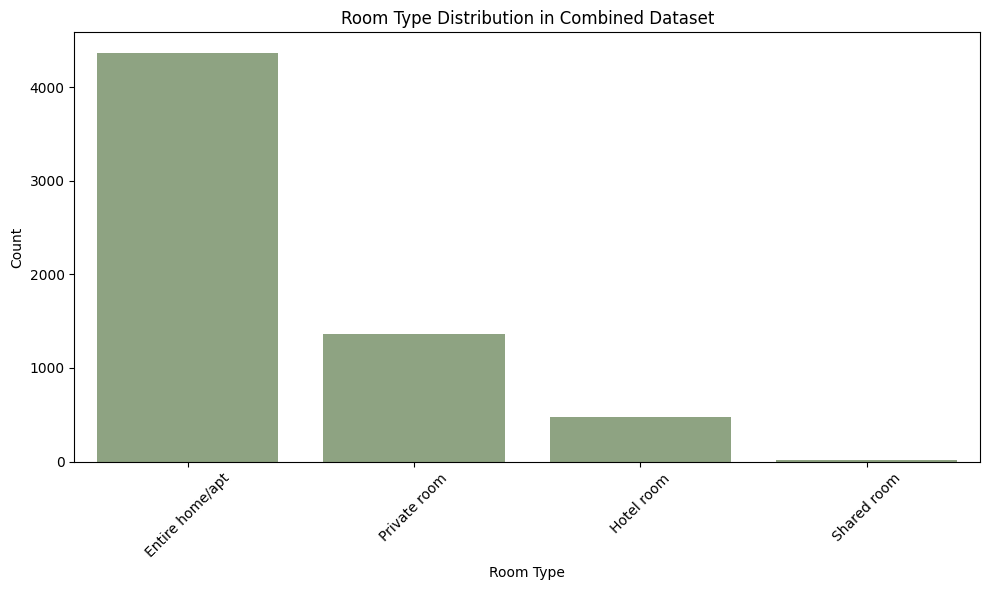

In [59]:
# Room type distribution in combined dataset and histogram

plt.figure(figsize=(10,6))
sns.countplot(data=df_no, x='room_type', color='#8ca87c', order=df_no['room_type'].value_counts().index)
plt.title('Room Type Distribution in Combined Dataset')
plt.xlabel('Room Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


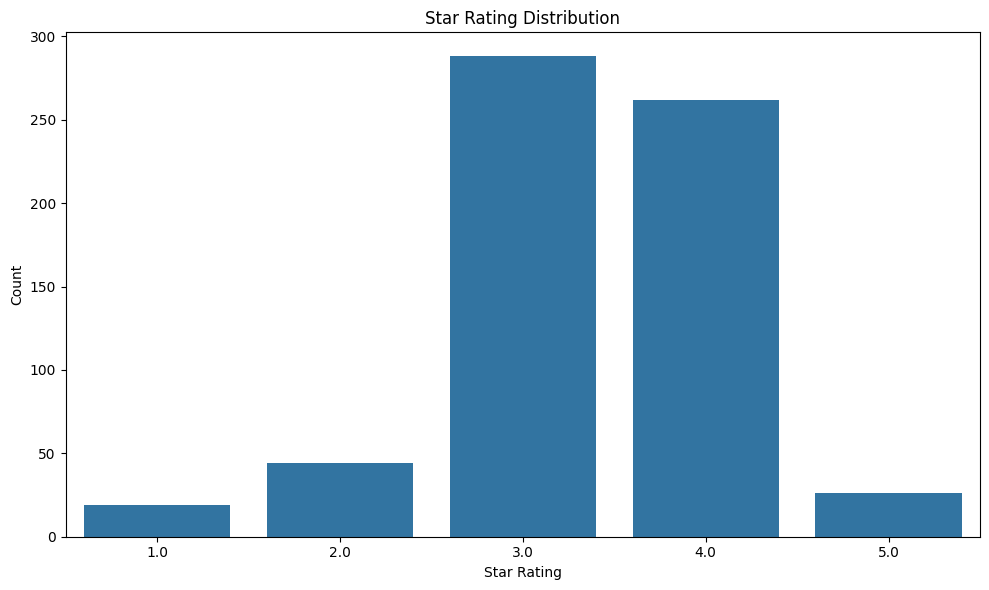

In [168]:
# Star rating distribution

plt.figure(figsize=(10,6))
sns.countplot(data=df_all, x='star_rating', order=sorted(df_all['star_rating'].dropna().unique()))
plt.title('Star Rating Distribution')
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

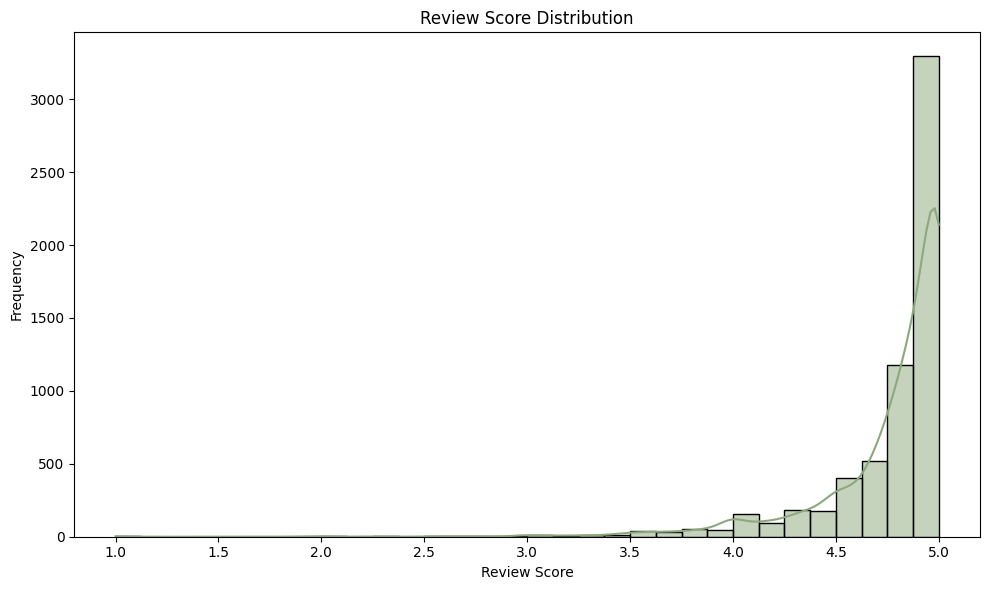

In [57]:
# Review score histogram

plt.figure(figsize=(10,6))
sns.histplot(df_no['review_score'], bins=32, kde=True, color='#8ca87c')
plt.title('Review Score Distribution')
plt.xlabel('Review Score')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

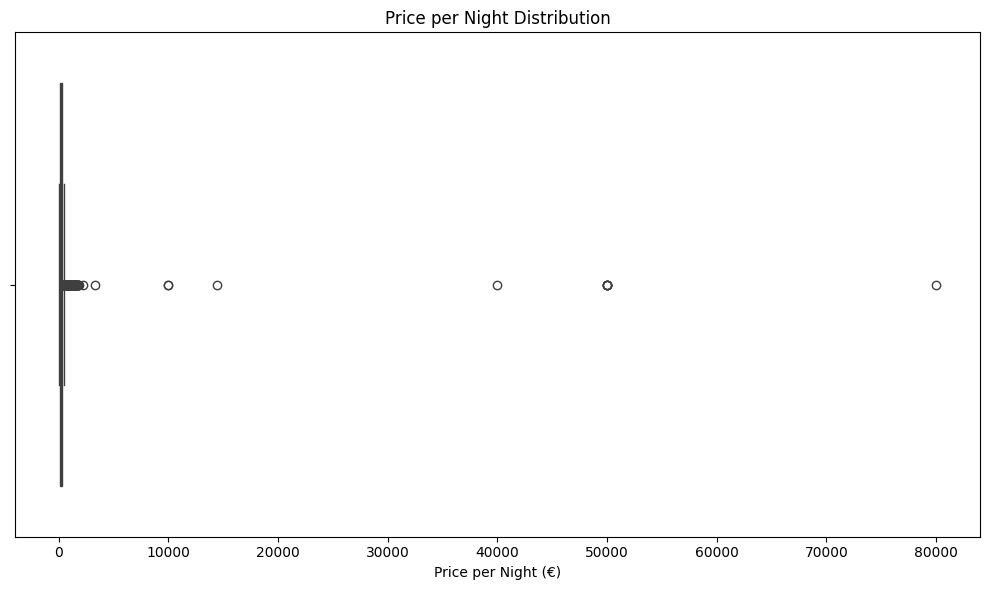

In [170]:
# Price per night boxplot to check for outliers

plt.figure(figsize=(10,6))
sns.boxplot(x=df_all['price'])
plt.title('Price per Night Distribution')
plt.xlabel('Price per Night (€)')
plt.tight_layout()
plt.show()

In [229]:
# Removing outliers using the IQR method

Q1 = df_all['price'].quantile(0.25)
Q3 = df_all['price'].quantile(0.75)
IQR = Q3 - Q1

# Keep only rows within 1.5*IQR
df_no = df_all[(df_all['price'] >= Q1 - 3*IQR) & (df_all['price'] <= Q3 + 3*IQR)]

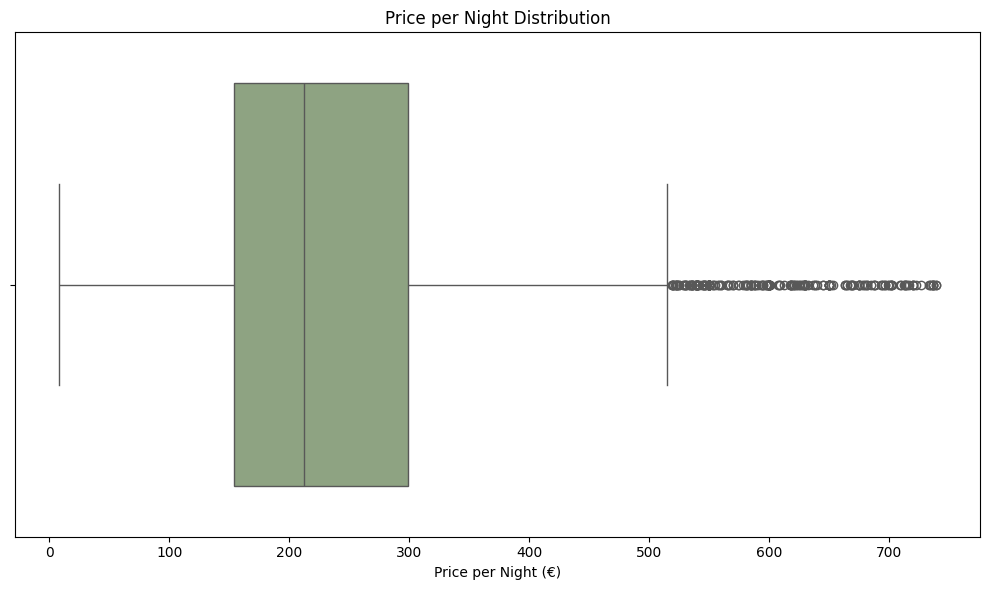

In [55]:
plt.figure(figsize=(10,6))
sns.boxplot(x=df_no['price'], color='#8ca87c')
plt.title('Price per Night Distribution')
plt.xlabel('Price per Night (€)')
plt.tight_layout()
plt.show()

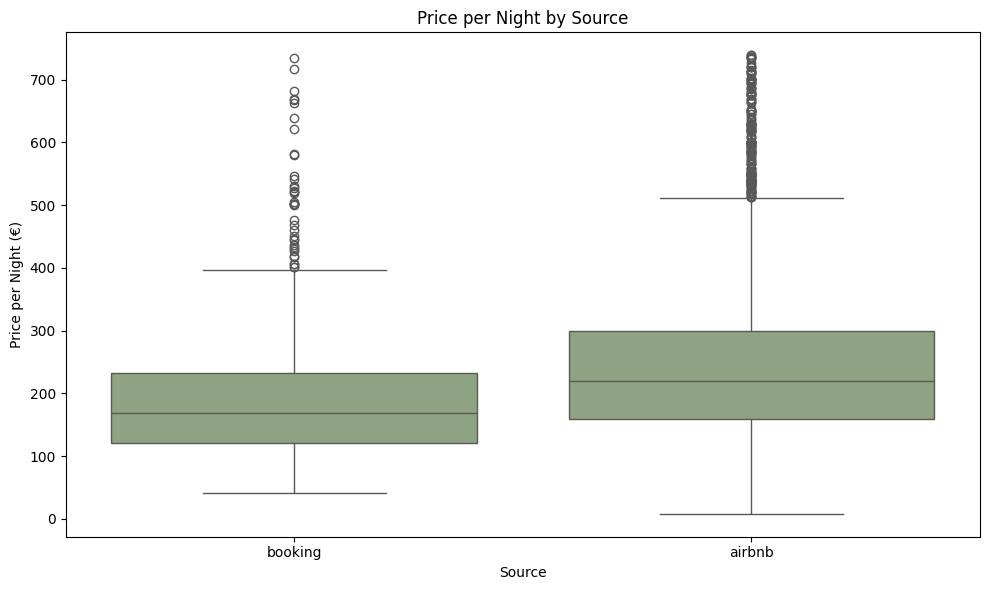

In [74]:
# Price per night boxplot, booking vs airbnb

plt.figure(figsize=(10,6))
sns.boxplot(x='source', y='price', data=df_no, color='#8ca87c')
plt.title('Price per Night by Source')
plt.xlabel('Source')
plt.ylabel('Price per Night (€)')
plt.tight_layout()
plt.show()

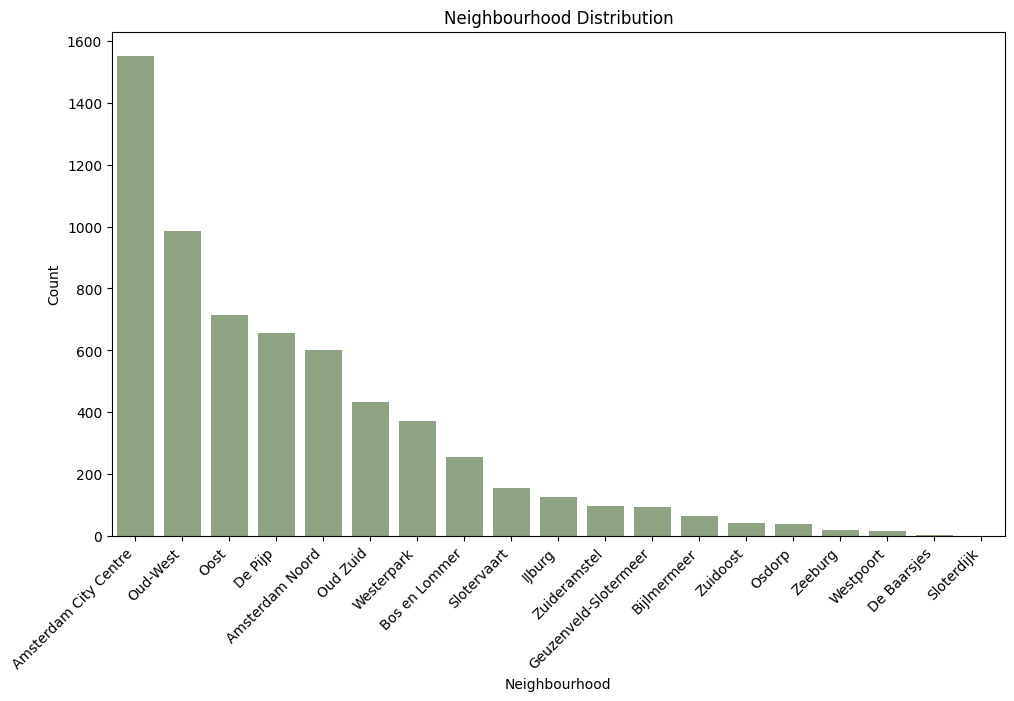

In [68]:
# Neighbourhood distribution

plt.figure(figsize=(10,6))
sns.countplot(data=df_no, x='neighbourhood', color='#8ca87c', order=df_no['neighbourhood'].value_counts().index)
plt.title('Neighbourhood Distribution')
plt.xlabel('Neighbourhood')
plt.ylabel('Count')
plt.tight_layout()
plt.xticks(rotation=45, ha="right")
plt.show()

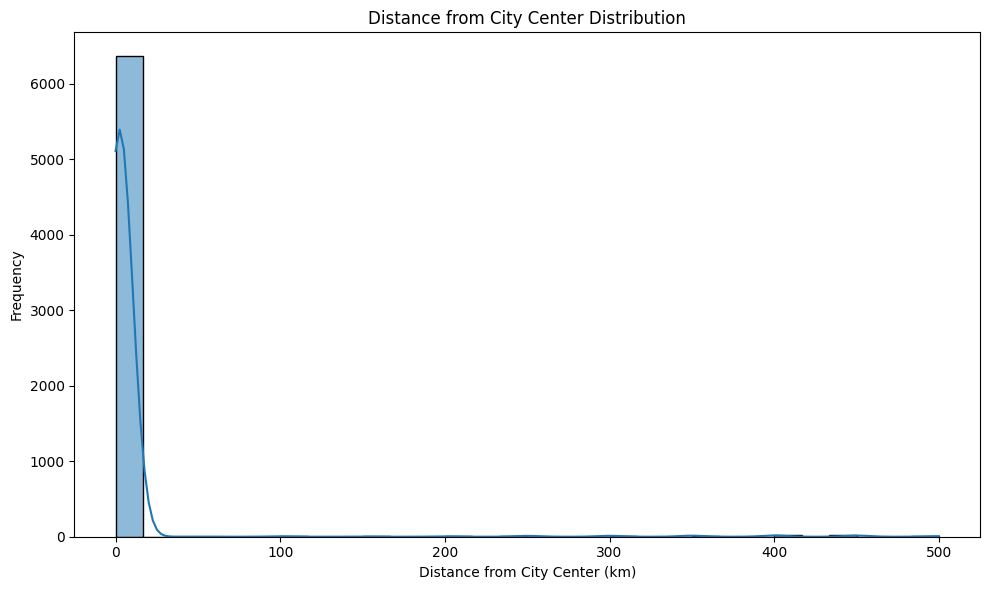

In [204]:
# Distance from city center histogram

plt.figure(figsize=(10,6))
sns.histplot(df_all['distance_from_center'], bins=30, kde=True)
plt.title('Distance from City Center Distribution')
plt.xlabel('Distance from City Center (km)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

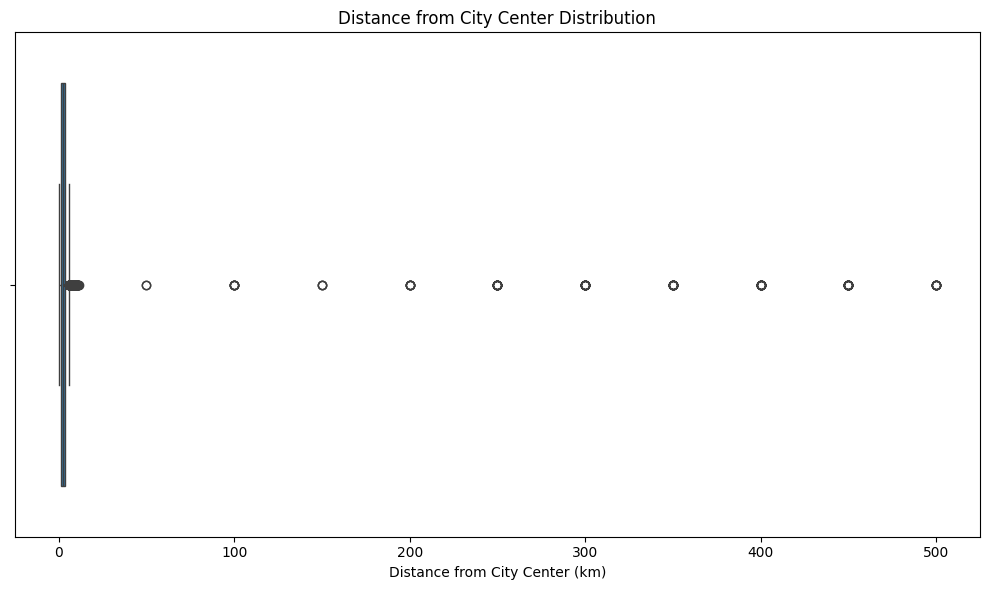

In [205]:
# Distance from center boxplot to check for outliers

plt.figure(figsize=(10,6))
sns.boxplot(x=df_all['distance_from_center'])
plt.title('Distance from City Center Distribution')
plt.xlabel('Distance from City Center (km)')
plt.tight_layout()
plt.show()

In [230]:
# Keep only properties within 20 km from city center

df_no = df_no[df_no['distance_from_center'] <= 20]

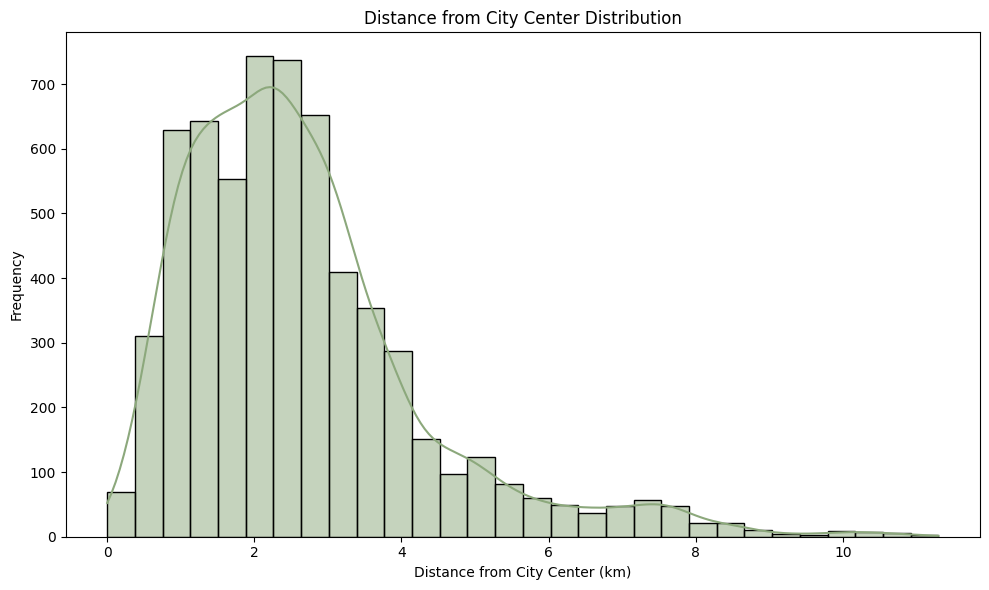

In [63]:
# Distance from city center histogram

plt.figure(figsize=(10,6))
sns.histplot(df_no['distance_from_center'], bins=30, kde=True, color='#8ca87c')
plt.title('Distance from City Center Distribution')
plt.xlabel('Distance from City Center (km)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

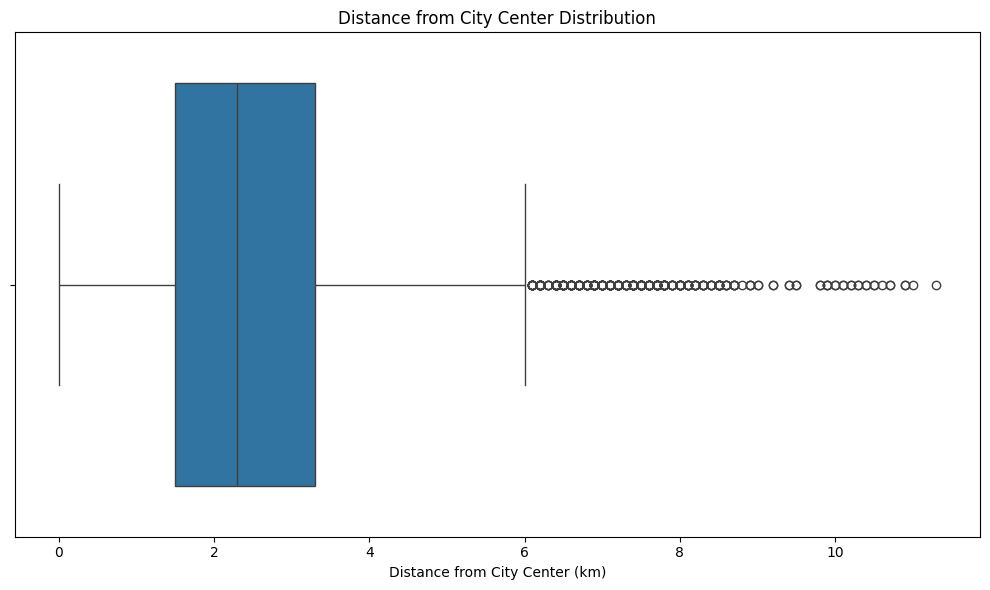

In [215]:
plt.figure(figsize=(10,6))
sns.boxplot(x=df_no['distance_from_center'])
plt.title('Distance from City Center Distribution')
plt.xlabel('Distance from City Center (km)')
plt.tight_layout()
plt.show()

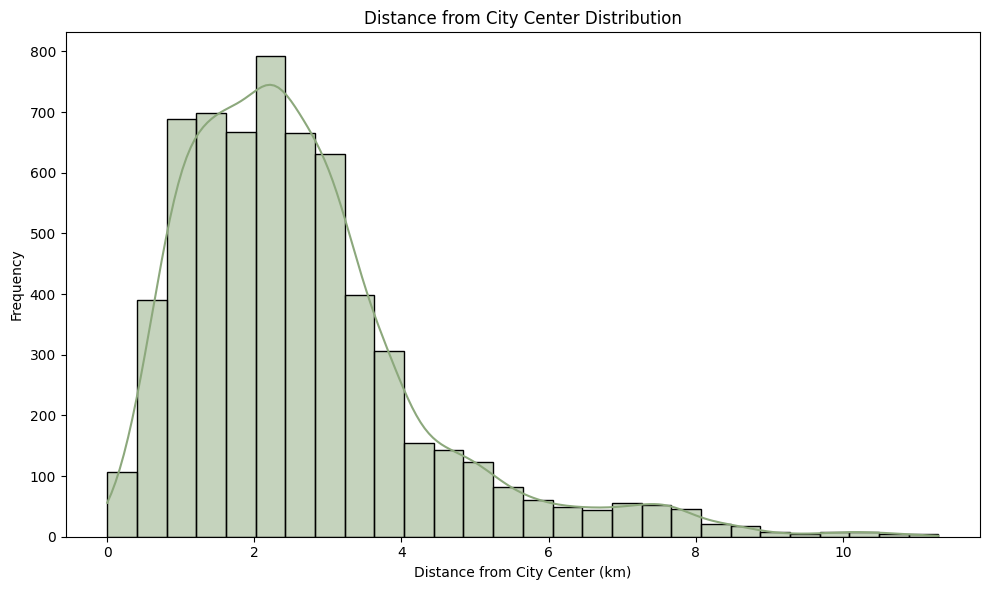

In [62]:
plt.figure(figsize=(10,6))
sns.histplot(df_no['distance_from_center'], bins=28, kde=True, color='#8ca87c')
plt.title('Distance from City Center Distribution')
plt.xlabel('Distance from City Center (km)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [52]:
print(df_all.shape)
print(df_no.shape)

NameError: name 'df_all' is not defined

### Exporting the final csv for Tableau

In [189]:
# Exporting the df_no as final csv for Tableau

df_no.to_csv('amsterdam_listings.csv', index=False)

In [53]:
df_no = pd.read_csv('amsterdam_listings.csv')

### Feature selection

In [54]:
df_no['source'].value_counts()

source
airbnb     5568
booking     656
Name: count, dtype: int64

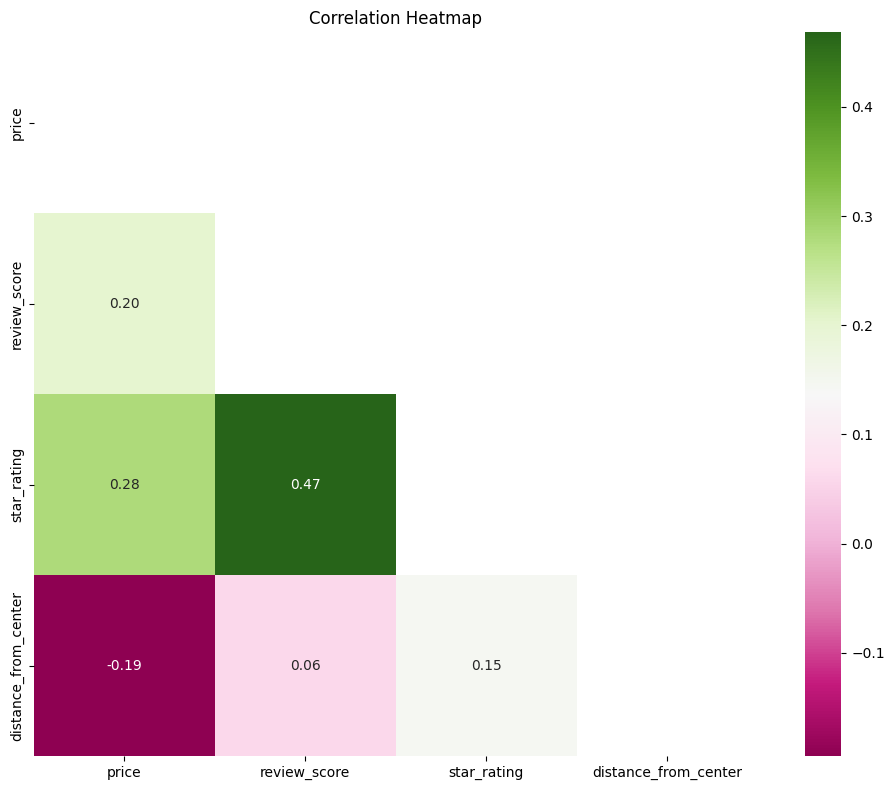

In [73]:
# Correlation heatmap

plt.figure(figsize=(10,8))
corr = df_no[['price', 'review_score', 'star_rating', 'distance_from_center']].corr()

# Create mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, mask=mask, annot=True, cmap='PiYG', fmt=".2f", square=True)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

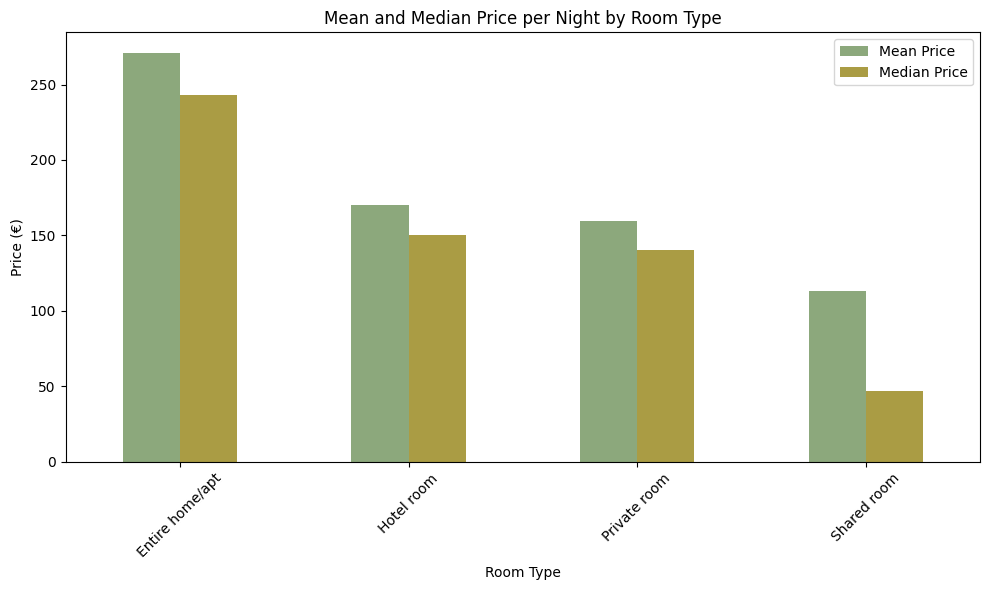

In [64]:
# Mean and median price per night by room type barchart

mean_prices = df_no.groupby('room_type')['price'].mean().round(2)
median_prices = df_no.groupby('room_type')['price'].median().round(2)
price_comparison = pd.DataFrame({'Mean Price': mean_prices, 'Median Price': median_prices}).reset_index()
price_comparison.plot(x='room_type', kind='bar', figsize=(10,6), color=['#8ca87c', '#aa9c44'])
plt.title('Mean and Median Price per Night by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Price (€)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

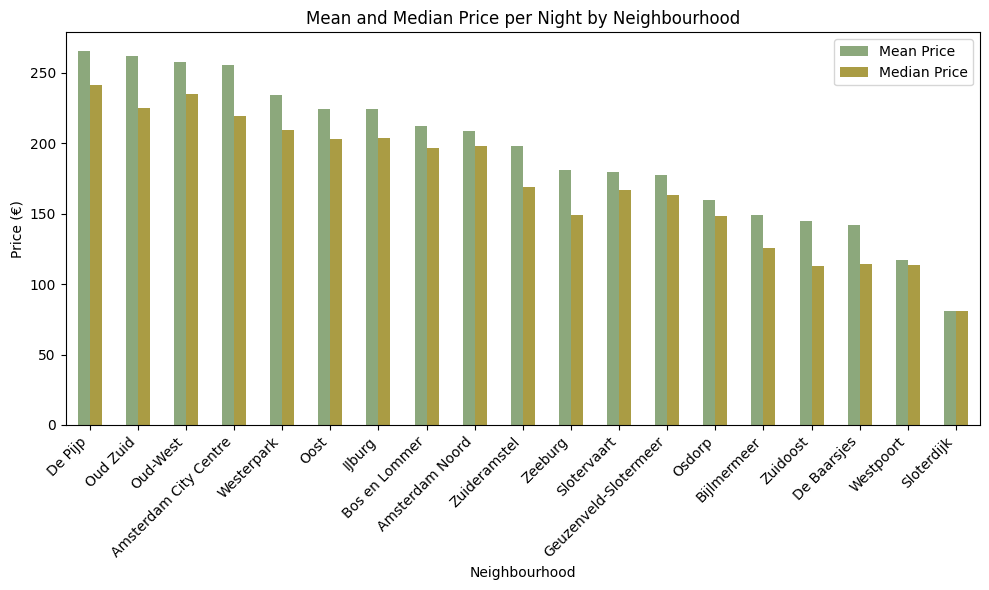

In [65]:
# Mean and median price per night by neighbourhood barchart

mean_prices = df_no.groupby('neighbourhood')['price'].mean().round(2)
median_prices = df_no.groupby('neighbourhood')['price'].median().round(2)

price_comparison = pd.DataFrame({
    'Mean Price': mean_prices,
    'Median Price': median_prices
}).reset_index()

# Sort by Mean Price (descending)
price_comparison = price_comparison.sort_values(by="Mean Price", ascending=False)

# Plot
price_comparison.plot(x='neighbourhood', kind='bar', figsize=(10,6), color=['#8ca87c', '#aa9c44'])
plt.title('Mean and Median Price per Night by Neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('Price (€)')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [7]:
# Dummy variables for room_type and neighbourhood

df_dummy = pd.get_dummies(df_no, columns=['room_type', 'neighbourhood'], dtype=int)
df_dummy.head()

,name,star_rating,review_score,price,latitude,longitude,distance_from_center,source,url,room_type_Entire home/apt,...,neighbourhood_Osdorp,neighbourhood_Oud Zuid,neighbourhood_Oud-West,neighbourhood_Sloterdijk,neighbourhood_Slotervaart,neighbourhood_Westerpark,neighbourhood_Westpoort,neighbourhood_Zeeburg,neighbourhood_Zuideramstel,neighbourhood_Zuidoost
0,The Muse Amsterdam - Boutique Hotel,3.0,4.15,111.71,52.353106,4.880981,2.3,booking,https://www.booking.com/hotel/nl/bronckhorst.e...,0,...,0,1,0,0,0,0,0,0,0,0
1,citizenM Amsterdam South,4.0,4.35,115.29,52.341942,4.875972,3.6,booking,https://www.booking.com/hotel/nl/citizenm-amst...,0,...,0,0,0,0,0,0,0,0,1,0
2,Ruby Emma Hotel Amsterdam,4.0,4.40,104.71,52.338310,4.920732,4.3,booking,https://www.booking.com/hotel/nl/ruby-emma.en-...,0,...,0,0,0,0,0,0,0,0,0,0
3,Inntel Hotels Amsterdam Landmark,4.0,4.10,167.86,52.373409,4.928381,2.4,booking,https://www.booking.com/hotel/nl/inntel-hotels...,0,...,0,0,0,0,0,0,0,0,0,0
4,Urban Lodge Hotel,4.0,4.15,96.00,52.385258,4.834363,4.2,booking,https://www.booking.com/hotel/nl/urban-lodge.e...,0,...,0,0,0,0,0,0,1,0,0,0


In [8]:
df_dummy.columns

Index(['name', 'star_rating', 'review_score', 'price', 'latitude', 'longitude',
       'distance_from_center', 'source', 'url', 'room_type_Entire home/apt',
       'room_type_Hotel room', 'room_type_Private room',
       'room_type_Shared room', 'neighbourhood_Amsterdam City Centre',
       'neighbourhood_Amsterdam Noord', 'neighbourhood_Bijlmermeer',
       'neighbourhood_Bos en Lommer', 'neighbourhood_De Baarsjes',
       'neighbourhood_De Pijp', 'neighbourhood_Geuzenveld-Slotermeer',
       'neighbourhood_IJburg', 'neighbourhood_Oost', 'neighbourhood_Osdorp',
       'neighbourhood_Oud Zuid', 'neighbourhood_Oud-West',
       'neighbourhood_Sloterdijk', 'neighbourhood_Slotervaart',
       'neighbourhood_Westerpark', 'neighbourhood_Westpoort',
       'neighbourhood_Zeeburg', 'neighbourhood_Zuideramstel',
       'neighbourhood_Zuidoost'],
      dtype='object')

### Modelling with feature set with neighbourhood

In [9]:
# Selecting the features and target variable for predictive modeling

# Feature set with neighbourhood
features_n = df_dummy.drop(['name', 'star_rating', 'price', 'latitude', 'longitude', 'source', 'url'], axis=1)
target = df_dummy['price']

X_train, X_test, y_train, y_test = train_test_split(features_n, target, test_size=0.20)

In [10]:
# Normalazing the features

normalizer = MinMaxScaler()

normalizer.fit(X_train)

X_train_norm = normalizer.transform(X_train)
X_test_norm = normalizer.transform(X_test)

In [11]:
X_train_norm = pd.DataFrame(X_train_norm, columns = X_train.columns)
X_test_norm = pd.DataFrame(X_test_norm, columns = X_test.columns)

#### Linear Regression

In [12]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_norm, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [13]:
# Predictions and evaluation

pred = lin_reg.predict(X_test_norm)

print("TEST DATA")
print("R2 score ", r2_score(y_test, pred))
print("RMSE ", mean_squared_error(y_test, pred))
print("MAE ", mean_absolute_error(y_test, pred))


print("----------------------------")

pred = lin_reg.predict(X_train_norm)

print("TRAIN DATA")
print("R2 score ", r2_score(y_train, pred))
print("RMSE ", mean_squared_error(y_train, pred))
print("MAE ", mean_absolute_error(y_train, pred))

TEST DATA
R2 score  0.23746001732932343
RMSE  11248.592319064091
MAE  78.30011163331368
----------------------------
TRAIN DATA
R2 score  0.25423683339154457
RMSE  10789.013579411472
MAE  77.18717047161383


#### Decision Tree

In [46]:
tree = DecisionTreeRegressor(random_state=42)
tree.fit(X_train_norm, y_train)

DecisionTreeRegressor(random_state=42)

In [47]:
# Predictions and evaluation

pred = tree.predict(X_test_norm)

print("TEST DATA")
print("R2 score ", r2_score(y_test, pred))
print("RMSE ", mean_squared_error(y_test, pred))
print("MAE ", mean_absolute_error(y_test, pred))


print("----------------------------")

pred = tree.predict(X_train_norm)

print("TRAIN DATA")
print("R2 score ", r2_score(y_train, pred))
print("RMSE ", mean_squared_error(y_train, pred))
print("MAE ", mean_absolute_error(y_train, pred))

TEST DATA
R2 score  -0.1235226510875631
RMSE  15701.753919948342
MAE  92.06557939569385
----------------------------
TRAIN DATA
R2 score  0.7141528675028412
RMSE  4190.746688444545
MAE  32.9025934602144


In [253]:
# Even worse that Linear Regression

#### Random Forest

In [48]:
forest = RandomForestRegressor(random_state=42)
forest.fit(X_train_norm, y_train)

RandomForestRegressor(random_state=42)

In [49]:
# Predictions and evaluation

pred = forest.predict(X_test_norm)

print("TEST DATA")
print("R2 score ", r2_score(y_test, pred))
print("RMSE ", mean_squared_error(y_test, pred))
print("MAE ", mean_absolute_error(y_test, pred))


print("----------------------------")

pred = forest.predict(X_train_norm)

print("TRAIN DATA")
print("R2 score ", r2_score(y_train, pred))
print("RMSE ", mean_squared_error(y_train, pred))
print("MAE ", mean_absolute_error(y_train, pred))

TEST DATA
R2 score  0.17855518221121713
RMSE  11480.07507926161
MAE  80.16721366824837
----------------------------
TRAIN DATA
R2 score  0.6583653936121079
RMSE  5008.635499928778
MAE  47.70468377514534


#### Xgboost

In [50]:
xgboost = XGBRegressor(random_state=42)
xgboost.fit(X_train_norm, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [51]:
# Predictions and evaluation

pred = xgboost.predict(X_test_norm)

print("TEST DATA")
print("R2 score ", r2_score(y_test, pred))
print("RMSE ", mean_squared_error(y_test, pred))
print("MAE ", mean_absolute_error(y_test, pred))


print("----------------------------")

pred = xgboost.predict(X_train_norm)

print("TRAIN DATA")
print("R2 score ", r2_score(y_train, pred))
print("RMSE ", mean_squared_error(y_train, pred))
print("MAE ", mean_absolute_error(y_train, pred))

TEST DATA
R2 score  0.17347368748730319
RMSE  11551.091341927235
MAE  80.93264196216629
----------------------------
TRAIN DATA
R2 score  0.5387555769725141
RMSE  6762.210701502016
MAE  58.02504241168009


In [20]:
# All models are quite bad

### Modelling with feature set with longitude and latitude


In [52]:
# Dropping values if latitude or longitude is null

df_dummy = df_dummy.dropna(subset=['latitude', 'longitude'])

In [53]:
# Feature set with longitude and latitude
features_l = df_dummy[['review_score', 'latitude', 'longitude', 'distance_from_center', 'room_type_Entire home/apt', 'room_type_Hotel room', 'room_type_Private room', 'room_type_Shared room']]
target = df_dummy['price']

X_train, X_test, y_train, y_test = train_test_split(features_l, target, test_size=0.20)

In [54]:
# Normalazing the features

normalizer = MinMaxScaler()

normalizer.fit(X_train)

X_train_norm = normalizer.transform(X_train)
X_test_norm = normalizer.transform(X_test)

In [55]:
X_train_norm = pd.DataFrame(X_train_norm, columns = X_train.columns)
X_test_norm = pd.DataFrame(X_test_norm, columns = X_test.columns)

#### Linear Regression

In [56]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_norm, y_train)

LinearRegression()

In [57]:
# Predictions and evaluation

pred = lin_reg.predict(X_test_norm)

print("TEST DATA")
print("R2 score ", r2_score(y_test, pred))
print("RMSE ", mean_squared_error(y_test, pred))
print("MAE ", mean_absolute_error(y_test, pred))


print("----------------------------")

pred = lin_reg.predict(X_train_norm)

print("TRAIN DATA")
print("R2 score ", r2_score(y_train, pred))
print("RMSE ", mean_squared_error(y_train, pred))
print("MAE ", mean_absolute_error(y_train, pred))

TEST DATA
R2 score  0.24554069591054628
RMSE  10884.11908888815
MAE  78.02645486206097
----------------------------
TRAIN DATA
R2 score  0.22630990433932252
RMSE  11280.846360152915
MAE  79.13117109074145


In [58]:
lin_reg_coef = {feature : coef for feature, coef in zip(X_train_norm.columns, lin_reg.coef_)}
lin_reg_coef

{'review_score': np.float64(170.36564382007018),
 'latitude': np.float64(-68.81020218187192),
 'longitude': np.float64(13.414133439039388),
 'distance_from_center': np.float64(-191.7143347908638),
 'room_type_Entire home/apt': np.float64(82.56998117659778),
 'room_type_Hotel room': np.float64(9.400128397678),
 'room_type_Private room': np.float64(-26.257448471504976),
 'room_type_Shared room': np.float64(-65.71266110277148)}

#### Decision Tree

In [59]:
tree = DecisionTreeRegressor(random_state=42)
tree.fit(X_train_norm, y_train)

DecisionTreeRegressor(random_state=42)

In [60]:
# Predictions and evaluation

pred = tree.predict(X_test_norm)

print("TEST DATA")
print("R2 score ", r2_score(y_test, pred))
print("RMSE ", mean_squared_error(y_test, pred))
print("MAE ", mean_absolute_error(y_test, pred))


print("----------------------------")

pred = tree.predict(X_train_norm)

print("TRAIN DATA")
print("R2 score ", r2_score(y_train, pred))
print("RMSE ", mean_squared_error(y_train, pred))
print("MAE ", mean_absolute_error(y_train, pred))

TEST DATA
R2 score  -0.43342371001431923
RMSE  20679.11984127629
MAE  104.39975358786894
----------------------------
TRAIN DATA
R2 score  0.9995794446473497
RMSE  6.131938803141078
MAE  0.10628215542919034


#### Random Forest

In [61]:
forest = RandomForestRegressor(random_state=42)
forest.fit(X_train_norm, y_train)

RandomForestRegressor(random_state=42)

In [62]:
pred = forest.predict(X_test_norm)

print("TEST DATA")
print("R2 score ", r2_score(y_test, pred))
print("RMSE ", mean_squared_error(y_test, pred))
print("MAE ", mean_absolute_error(y_test, pred))


print("----------------------------")

pred = forest.predict(X_train_norm)

print("TRAIN DATA")
print("R2 score ", r2_score(y_train, pred))
print("RMSE ", mean_squared_error(y_train, pred))
print("MAE ", mean_absolute_error(y_train, pred))

TEST DATA
R2 score  0.24304292396601035
RMSE  10920.15290430252
MAE  77.97791498588063
----------------------------
TRAIN DATA
R2 score  0.8948254354055537
RMSE  1533.505612699842
MAE  28.489560980716416


#### XGBoost

In [63]:
xgboost = XGBRegressor(random_state=42)
xgboost.fit(X_train_norm, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [64]:
# Predictions and evaluation

pred = xgboost.predict(X_test_norm)

print("TEST DATA")
print("R2 score ", r2_score(y_test, pred))
print("RMSE ", mean_squared_error(y_test, pred))
print("MAE ", mean_absolute_error(y_test, pred))


print("----------------------------")

pred = xgboost.predict(X_train_norm)

print("TRAIN DATA")
print("R2 score ", r2_score(y_train, pred))
print("RMSE ", mean_squared_error(y_train, pred))
print("MAE ", mean_absolute_error(y_train, pred))

TEST DATA
R2 score  0.20051113514023722
RMSE  11533.732791426915
MAE  80.29684249109413
----------------------------
TRAIN DATA
R2 score  0.7550090413504428
RMSE  3572.1090132247573
MAE  42.75042045343803


### Hyperparameter tuning
Logical regression with neighbourhood

#### Ridge Regression (L2 regularization)

In [32]:
ridge_params = {
    "alpha": [0.01, 0.1, 1, 10, 100, 500, 1000]  # strength of regularization
}

ridge = Ridge(max_iter=10000)

ridge_grid = GridSearchCV(
    ridge,
    ridge_params,
    cv=5,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
)
ridge_grid.fit(X_train, y_train)

print("Best alpha:", ridge_grid.best_params_["alpha"])
print("Best CV score:", -ridge_grid.best_score_)

Best alpha: 1
Best CV score: 77.44889945598429


#### Lasso Regression (L1 regularization)

In [36]:
lasso_params = {
    "alpha": [0.005, 0.01, 0.05, 1, 10, 100]
}

lasso = Lasso(max_iter=10000)

lasso_grid = GridSearchCV(
    lasso,
    lasso_params,
    cv=5,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
)
lasso_grid.fit(X_train, y_train)

print("Best alpha:", lasso_grid.best_params_["alpha"])
print("Best CV score:", -lasso_grid.best_score_)

Best alpha: 0.05
Best CV score: 77.43948073605523


#### ElasticNet (L1 + L2 mix)

In [38]:
enet_params = {
    "alpha": [0.001, 0.002, 0.005],
    "l1_ratio": [0.1, 0.3, 0.6, 0.7, 0.9]  # 0 = Ridge, 1 = Lasso
}

enet = ElasticNet(max_iter=10000)

enet_grid = GridSearchCV(
    enet,
    enet_params,
    cv=5,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
)
enet_grid.fit(X_train, y_train)

print("Best params:", enet_grid.best_params_)
print("Best CV score:", -enet_grid.best_score_)

Best params: {'alpha': 0.002, 'l1_ratio': 0.9}
Best CV score: 77.44857699096495


### Implementing the best mode

Why LinearRegression might be best
	
	•	No penalty (α=0) → The model uses all features fully without shrinking any coefficients.
	•	Your features are strong → If the dataset has well-behaved predictors (not too correlated, not too many irrelevant ones), regularization might not add much benefit.
	•	Cross-validation confirmed it → If LinearRegression gave the highest CV score, that means the penalty terms from Ridge/Lasso didn’t improve generalization.


In [44]:
final_model = LinearRegression()
final_model.fit(X_train, y_train)

# Predictions and evaluation

pred = lin_reg.predict(X_test_norm)

print("TEST DATA")
print("R2 score ", r2_score(y_test, pred))
print("RMSE ", mean_squared_error(y_test, pred))
print("MAE ", mean_absolute_error(y_test, pred))


print("----------------------------")

pred = lin_reg.predict(X_train_norm)

print("TRAIN DATA")
print("R2 score ", r2_score(y_train, pred))
print("RMSE ", mean_squared_error(y_train, pred))
print("MAE ", mean_absolute_error(y_train, pred))

TEST DATA
R2 score  0.23746001732932343
RMSE  11248.592319064091
MAE  78.30011163331368
----------------------------
TRAIN DATA
R2 score  0.25423683339154457
RMSE  10789.013579411472
MAE  77.18717047161383


In [51]:
lin_reg_coef = {feature : coef for feature, coef in zip(X_train_norm.columns, lin_reg.coef_)}

# Convert dictionary to Series
lin_reg_coef_series = pd.Series(lin_reg_coef)

# Sort descending
lin_reg_coef_sorted = lin_reg_coef_series.sort_values(ascending=False)

lin_reg_coef_sorted

review_score                           167.635147
room_type_Entire home/apt              101.230791
neighbourhood_IJburg                    62.827058
neighbourhood_Zuidoost                  60.591528
neighbourhood_Oud Zuid                  29.142238
neighbourhood_Bijlmermeer               27.793794
neighbourhood_Osdorp                    23.116674
neighbourhood_Zuideramstel              17.684017
room_type_Hotel room                    15.431922
neighbourhood_Geuzenveld-Slotermeer     14.495777
neighbourhood_Amsterdam City Centre      6.854909
neighbourhood_De Pijp                    4.327289
neighbourhood_Oud-West                   0.731967
neighbourhood_Zeeburg                   -0.195229
neighbourhood_Amsterdam Noord           -3.214522
neighbourhood_Slotervaart               -6.281374
room_type_Private room                 -13.459084
neighbourhood_Oost                     -18.838849
neighbourhood_Westerpark               -30.503768
neighbourhood_Westpoort                -33.941793
